In [214]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import os
import cv2
import sklearn
from sklearn import metrics
from matplotlib import pyplot as plt

In [215]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Load Dataset

In [216]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [217]:
images_folder = os.path.join("/content/drive/My Drive/College/Slash_Tasks/dataset")

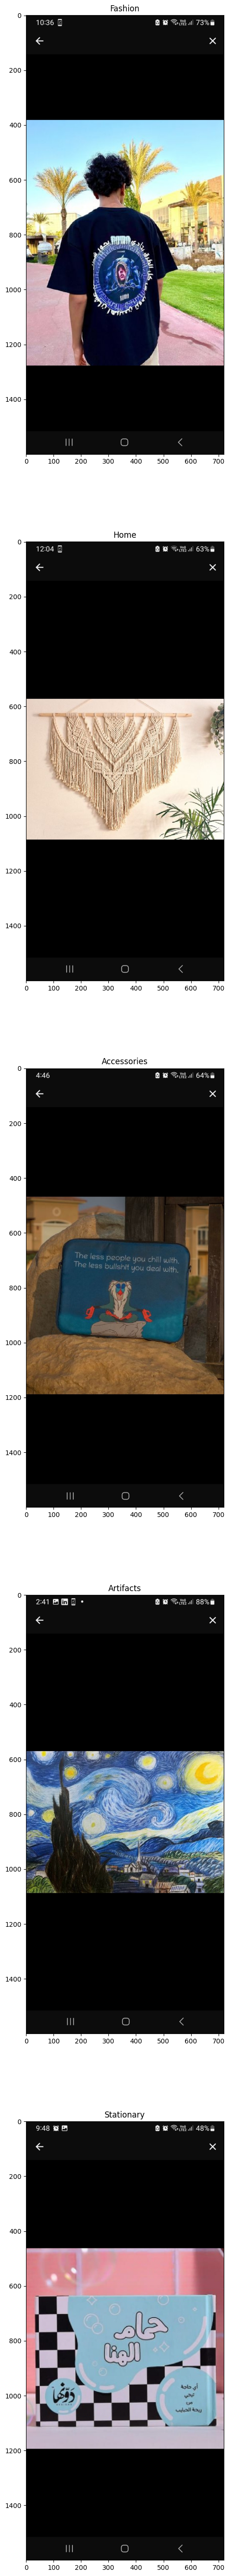

In [218]:
num_classes = 5
classes_names = []
class_num = 0
fig = plt.figure(figsize=(100, 70))
for image_class in os.listdir(images_folder):
  class_num += 1
  classes_names.append(image_class)
  for image in os.listdir(os.path.join(images_folder, image_class)):
      image_path = os.path.join(images_folder, image_class, image)
      img = cv2.imread(image_path)
      rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      fig.add_subplot(num_classes, 1, class_num)
      plt.title(image_class)
      plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      break

In [219]:
data = tf.keras.utils.image_dataset_from_directory("/content/drive/My Drive/College/Slash_Tasks/dataset")

Found 475 files belonging to 5 classes.


## Preprocessing Data

### Scale Data

In [220]:
data = data.map(lambda x, y: (x/255, y))

In [221]:
data_iterator = data.as_numpy_iterator()

### Partition Data

In [222]:
data_len = len(data)

In [223]:
train_size = round(data_len*.7)
val_size = round(data_len*.2)
test_size = round(data_len*.1) - 1

In [224]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

### Network Model

In [225]:
# Build the CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(256,256,3)),
    tf.keras.layers.Conv2D(64, kernel_size=(6, 6), padding='valid', activation='relu'),
    tf.keras.layers.BatchNormalization(momentum=0.95),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), padding='valid', activation='relu'),
    tf.keras.layers.BatchNormalization(momentum=0.95),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(momentum=0.95),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.BatchNormalization(momentum=0.95),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [226]:
# Compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [227]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 251, 251, 64)      6976      
                                                                 
 batch_normalization_60 (Ba  (None, 251, 251, 64)      256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 125, 125, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (None, 123, 123, 16)      9232      
                                                                 
 batch_normalization_61 (Ba  (None, 123, 123, 16)      64        
 tchNormalization)                                               
                                                     

In [228]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')

In [229]:
trained_model = model.fit(train, epochs=50, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/50
10/10 [==============================] - 11s 612ms/step - loss: 1.4946 - accuracy: 0.4094 - val_loss: 1.6463 - val_accuracy: 0.2396
Epoch 2/50
10/10 [==============================] - 7s 569ms/step - loss: 0.9294 - accuracy: 0.6906 - val_loss: 1.6215 - val_accuracy: 0.3438
Epoch 3/50
10/10 [==============================] - 9s 601ms/step - loss: 1.0001 - accuracy: 0.6906 - val_loss: 1.7391 - val_accuracy: 0.3125
Epoch 4/50
10/10 [==============================] - 9s 732ms/step - loss: 0.8120 - accuracy: 0.7094 - val_loss: 1.8178 - val_accuracy: 0.3229
Epoch 5/50
10/10 [==============================] - 7s 574ms/step - loss: 0.7085 - accuracy: 0.7750 - val_loss: 1.4666 - val_accuracy: 0.4167
Epoch 6/50
10/10 [==============================] - 8s 700ms/step - loss: 0.5789 - accuracy: 0.8062 - val_loss: 1.3116 - val_accuracy: 0.4688
Epoch 7/50
10/10 [==============================] - 8s 638ms/step - loss: 0.3866 - accuracy: 0.9281 - val_loss: 1.1763 - val_accuracy: 0.6042
Epoch

In [230]:
test_loss, test_accuracy = model.evaluate(test)
print("Test Accuracy: ", test_accuracy)
print("Test Loss: ", test_loss)

1/1 [==============================] - 5s 5s/step - loss: 0.0045 - accuracy: 1.0000
Test Accuracy:  1.0
Test Loss:  0.004483456257730722


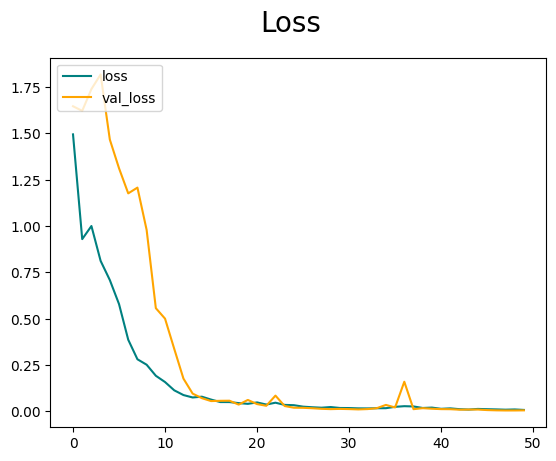

In [231]:
fig = plt.figure()
plt.plot(trained_model.history['loss'], color='teal', label='loss')
plt.plot(trained_model.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

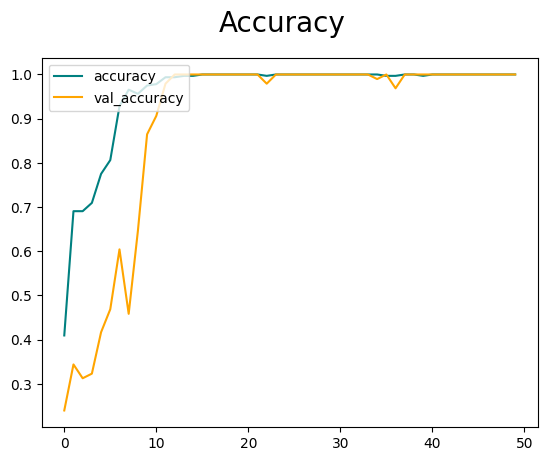

In [232]:
fig = plt.figure()
plt.plot(trained_model.history['accuracy'], color='teal', label='accuracy')
plt.plot(trained_model.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [233]:
y = []
y_pred = []
for images, labels in test:
  for image, label in zip(images, labels):
    y.append(label.numpy())
    pred = np.argmax(model.predict(np.expand_dims(image, axis=0)), axis=1)[0]
    y_pred.append(pred)

1/1 [==============================] - 0s 28ms/step


In [234]:
metrics.accuracy_score(y, y_pred)

1.0

<Axes: >

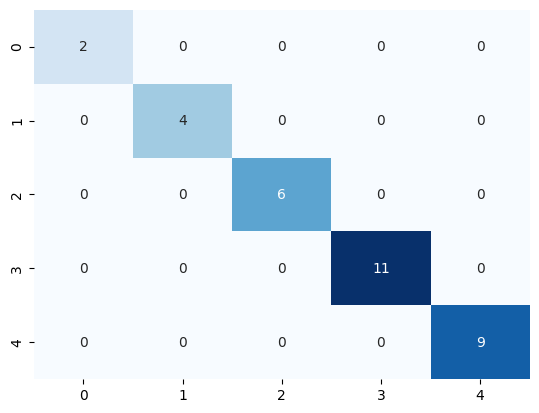

In [235]:
confusion_matrix = metrics.confusion_matrix(y, y_pred)
sns.heatmap(confusion_matrix, cmap='Blues', cbar=False, annot=True)

In [237]:
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00         9

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32

